In [3]:
# Data visualization
import matplotlib.pyplot as plt
import cartopy

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# todo: mount GPU on colab.

In [4]:
repo_root = '../' # use 'climate-emulator-tutorial/' on colab and '../' on local machine
data_root = repo_root + 'data/'

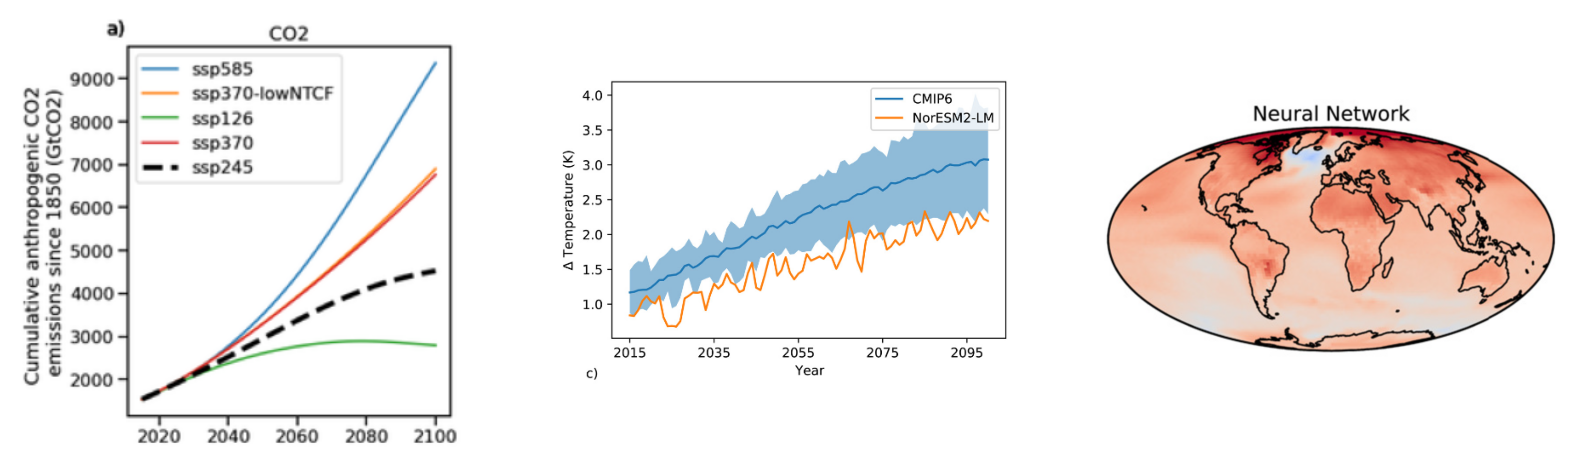

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import math

images = []
images.append(repo_root+'figures/tutorial/co2_over_time_per_scenario_climatebench.png')
images.append(repo_root+'figures/tutorial/global_t_over_time_in_ssp245.png')
images.append(repo_root+'figures/tutorial/t_over_space_avg_2080_2100_ssp245.png')

plt.figure(figsize=(20,10))
columns = 3
for i, image in enumerate(images):
    plt.subplot(math.ceil(len(images) / columns), columns, i + 1)
    im = Image.open(image)
    plt.imshow(im)
    plt.axis('off')

In [6]:
#@title code: load ClimateBench data
from emcli.data.climatebench import load_climatebench_train_data

scenarios = ['ssp126','ssp370','ssp585','hist-GHG','hist-aer']
len_historical = 165
data_path = data_root + '/'

X_train, Y_train = load_climatebench_train_data(
  simus=scenarios, len_historical=len_historical, 
  data_path=data_path)


Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp126
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp370
Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp585
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-GHG
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-aer


In [7]:
print('Number of training scenarios:', len(X_train))
print('Inputs:')
print('\tInput channels:', ', '.join(list(X_train[0].data_vars)))
print(f'\tThe scenarios have {X_train[0]["CO2"].shape} time steps in (ssp) scenarios and {X_train[3]["CO2"].shape} in (historical).')
print(f'\tCO2 and CH4 are global [{X_train[0]["CO2"].shape}, {X_train[0]["CH4"].shape}], while SO2 and BC are spatially resolved [{X_train[0]["SO2"].shape}, {X_train[0]["BC"].shape}].')
print('Outputs:')
print('\tOutput channels:', ', '.join(list(Y_train[0].data_vars)))
print(f'\tAll outputs are spatially resolved: {Y_train[0]["tas"].shape} (ssp) or {Y_train[3]["tas"].shape} (historical).')

Number of training scenarios: 5
Inputs:
	Input channels: CO2, SO2, CH4, BC
	The scenarios have (251,) time steps in (ssp) scenarios and (165,) in (historical).
	CO2 and CH4 are global [(251,), (251,)], while SO2 and BC are spatially resolved [(251, 96, 144), (251, 96, 144)].
Outputs:
	Output channels: diurnal_temperature_range, tas, pr, pr90
	All outputs are spatially resolved: (251, 96, 144) (ssp) or (165, 96, 144) (historical).


### The global cumulative CO2 emissions and temperature anomaly correlate approximately linear on a 10yr time-scale.

- Linear assumption breaks down in aerosol-only experiment (hist-AER)
- Why does the NorESM2 model underestimate warming in 1960-2010? Am I misunderstanding hist-GHG or did they only calibrate their model on 1850-1960? How do people know that climate models are not overfitted?

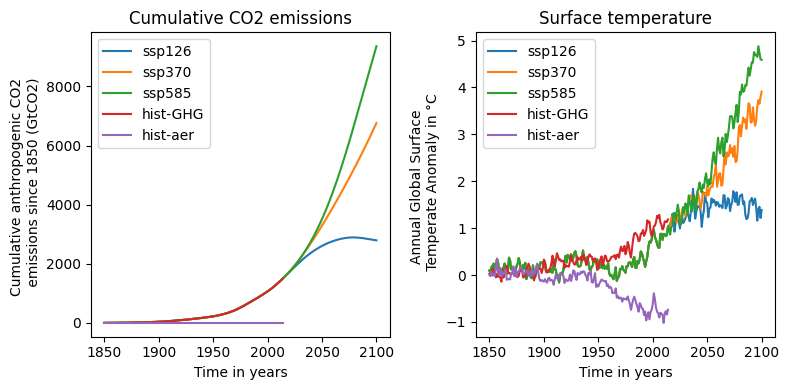

In [8]:
fig, axs = plt.subplots(1,2, figsize =(8,4))

# Plot global cumulative CO2 emissions over time
for idx, scenario in enumerate(('ssp126', 'ssp370', 'ssp585', 'hist-GHG', 'hist-aer')):
    axs[0].plot(X_train[idx].time, X_train[idx]['CO2'], label=scenario)
axs[0].set_xlabel("Time in years")
axs[0].set_ylabel("Cumulative anthropogenic CO2 \n emissions since 1850 (GtCO2)")
axs[0].set_title("Cumulative CO2 emissions")
axs[0].legend()

# Plot global surface temperature over time
for idx, scenario in enumerate(('ssp126', 'ssp370', 'ssp585', 'hist-GHG', 'hist-aer')):
    axs[1].plot(Y_train[idx].time, Y_train[idx]['tas'].mean(axis=(1,2)), label=scenario)
axs[1].set_xlabel("Time in years")
axs[1].set_ylabel("Annual Global Surface \n Temperate Anomaly in °C")
axs[1].set_title("Surface temperature")
axs[1].legend()
plt.tight_layout()

### Calculate statistics of all variables
- There's an maximum annual temperature anomaly of 14°C. That's very high.

In [9]:
import numpy as np 
from emcli.data.utils import calc_statistics

# Usage: min,max,mean,std = calc_statistics(Y_train, var_key='tas')
print(f'The annual, locally-resolved data has the following statistics:')
print(f'\t\t\t\t\t min \t max \t\t mean \t\t std.dev.')
min,max,mean,std = calc_statistics(Y_train, var_key='tas')
print(f'Surface Temp. anomaly \tin °C: \t\t {min:.2f} \t {max:.2f} \t\t {mean:.2f} \t\t {std:.2f}')
min,max,mean,std = calc_statistics(X_train, var_key='CO2')
print(f'Cum. CO2. emissions \tin GtCO2: \t {min:.2f} \t {max:.2f} \t {mean:.2f} \t {std:.2f}')
min,max,mean,std = calc_statistics(X_train, var_key='CH4')
print(f'CH4 emissions \t\tin GtCH4/yr: \t {min:.2f} \t {max:.2f} \t\t {mean:.2f} \t\t {std:.2f}')
min,max,mean,std = calc_statistics(X_train, var_key='SO2')
print(f'SO2 emissions \t\tin TgSO2/yr: \t {min:.2f} \t {max:.2f} \t\t {mean:.2f} \t\t {std:.2f}')
min,max,mean,std = calc_statistics(X_train, var_key='BC')
print(f'BC emissions \t\tin TgBC/yr: \t {min:.2f} \t {max:.2f} \t\t {mean:.2f} \t\t {std:.2f}')

The annual, locally-resolved data has the following statistics:
					 min 	 max 		 mean 		 std.dev.
Surface Temp. anomaly 	in °C: 		 -6.09 	 14.74 		 0.56 		 1.13
Cum. CO2. emissions 	in GtCO2: 	 0.00 	 9362.59 	 948.92 	 1194.43
CH4 emissions 		in GtCH4/yr: 	 0.00 	 0.75 		 0.18 		 0.12
SO2 emissions 		in TgSO2/yr: 	 0.00 	 0.00 		 0.00 		 0.00
BC emissions 		in TgBC/yr: 	 0.00 	 0.00 		 0.00 		 0.00


### Create histograms
- The CO2 data is very imbalanced towards 0 emission profiles (is that due to hist-AER?)
- The surface temps are almost skew normal distributed, with a skew towards positive values 

100%|██████████| 5/5 [00:00<00:00, 29.30it/s]


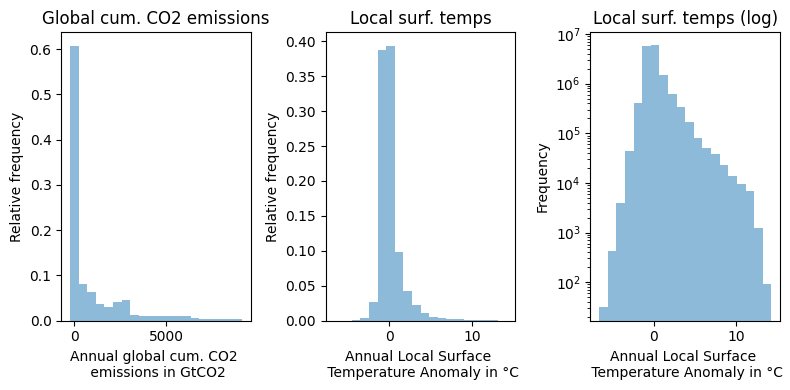

In [10]:
# Initialize an empty array to store the histogram values
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from emcli.data.utils import create_histogram
from emcli.utils.plotting import plot_histogram

fig, axs = plt.subplots(1,3, figsize =(8, 4))
# Plot CO2 emissions histogram
n_bins = 20
hist, bin_values = create_histogram(data=X_train, var_key='CO2', n_bins=n_bins)
axs[0] = plot_histogram(hist, bin_values, 
        xlabel="Annual global cum. CO2 \n emissions in GtCO2",
        ylabel="Relative frequency",
        title="Global cum. CO2 emissions",
        ax=axs[0])
# Plot local temperatures histogram
n_bins = 20
hist, bin_values = create_histogram(data=Y_train, var_key='tas', n_bins=n_bins)
axs[1] = plot_histogram(hist, bin_values, 
        xlabel="Annual Local Surface \n Temperature Anomaly in °C",
        ylabel="Relative frequency",
        title="Local surf. temps",
        ax=axs[1])

# Plot log-scale local temperatures histogram
n_bins = 20
hist, bin_values = create_histogram(data=Y_train, var_key='tas', n_bins=n_bins, normalize=False)
axs[2] = plot_histogram(hist, bin_values, 
        xlabel="Annual Local Surface \n Temperature Anomaly in °C",
        ylabel="Frequency",
        title="Local surf. temps (log)",
        ax=axs[2])
axs[2].set_yscale('log')

plt.tight_layout()

100%|██████████| 5/5 [00:00<00:00, 4372.71it/s]


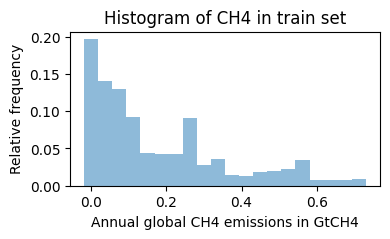

In [11]:
# Plot secondary greenhouse gases (todo: add bc, so2)
n_bins = 20
hist, bin_values = create_histogram(data=X_train, var_key='CH4', n_bins=n_bins)
ax = plot_histogram(hist, bin_values, 
        xlabel="Annual global CH4 emissions in GtCH4",
        ylabel="Relative frequency",
        title="Histogram of CH4 in train set")

### Could I map co2 onto temperature by eye?

- Mapping global CO2 to locally-resolved temperature by eye is impossible due to internal variability of the model 
    - => There's little value in learning a time-instant mapping from annual global CO2 concentrations to annual locally resolved tas.
- Are the any multi-year trends that the model could learn to predict in an autoregressive mapping?
- I can see ENSE patterns, North Atlantic cold blob, stronger warming in Northern Hemisphere

In [12]:
import hvplot.xarray
import panel.widgets as pnw
# hvplot.extension('bokeh')
scenario_id = 1
clim = (Y_train[scenario_id]['tas'].data.min(),Y_train[scenario_id]['tas'].data.max())
Y_train[scenario_id]['tas'].interactive.sel(time=pnw.DiscreteSlider).hvplot(cmap='coolwarm', clim=clim, coastline=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'e8ae44c8-80b3-419a-b14b-93dae969c065': {'version…

In [13]:
""" Interactive geospatial plot
import hvplot.xarray
import panel.widgets as pnw
import cartopy.crs as crs
# src: https://hvplot.holoviz.org/

Y_train[scenario_id]['tas'].interactive.sel(time=pnw.DiscreteSlider).hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.Mollweide(),# project=True,
    cmap='viridis', coastline=True # global_extent=True, 
)
"""

" Interactive geospatial plot\nimport hvplot.xarray\nimport panel.widgets as pnw\nimport cartopy.crs as crs\n# src: https://hvplot.holoviz.org/\n\nY_train[scenario_id]['tas'].interactive.sel(time=pnw.DiscreteSlider).hvplot.quadmesh(\n    'longitude', 'latitude', projection=crs.Mollweide(),# project=True,\n    cmap='viridis', coastline=True # global_extent=True, \n)\n"

### Is local temperature just a locally linear function of global temp.?
- For the most part, yes. However, the linear assumption does not seem to capture all correlations.
- The internal variability might already be capture by the global temp. So, the mapping from global to local temp seems easier.

In [14]:
# Retrieve data 

scenario_id = 1 # 1: ssp370
n_t = Y_train[scenario_id].time.size
n_lat = Y_train[scenario_id].latitude.size
n_lon = Y_train[scenario_id].longitude.size

# Retrieve global temperatures
tas_global = Y_train[scenario_id]['tas'].mean(axis=(1,2)).data # spatial average
# Retrieve annual local temperature field
tas_local = Y_train[scenario_id]['tas'].data

tas_global.shape, tas_local.shape

((251,), (251, 96, 144))

In [15]:
# Fit a globally linear model

from sklearn.linear_model import LinearRegression

def fit_globally_linear(tas_global, tas_local):
    """
    Fits a linear model from global temperatures to local 
    temperatures, independent of location. This model will
    ignore all spatial patterns. Returns fit of linear model
    on training data.
    Args:
        tas_global np.array((n_t,))
        tas_local np.array((n_t,n_lat,n_lon))
    Returns:
        preds np.array((n_t, n_lat, n_lon))
    """
    # Process data for linear regression
    ## Repeat global temperature onto locally-resolved grid 
    tas_global = np.tile(tas_global[:,np.newaxis, np.newaxis], reps=(1,n_lat,n_lon)) 
    ## Flatten both arrays
    tas_local = tas_local.flatten()[:,np.newaxis]
    tas_global = tas_global.flatten()[:,np.newaxis]

    # Initialize and fit a LinearRegression model
    model = LinearRegression()
    model.fit(tas_global, tas_local)

    # Make predictions
    preds = model.predict(tas_global)

    # Postprocess data: Reshape onto locally-resovled grid
    preds = preds.reshape((n_t, n_lat, n_lon))
    
    return preds

preds_global_lin = fit_globally_linear(tas_global, tas_local)
preds_global_lin.shape

(251, 96, 144)

In [22]:
## Fit pattern scaling model and do inference on training data

from emcli.models.pattern_scaling.model import PatternScaling

pattern_scaling = PatternScaling(deg=1)
pattern_scaling.train(tas_global, tas_local)
preds_pattern_scaling = pattern_scaling.predict(tas_global)
preds_pattern_scaling.shape

(251, 96, 144)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


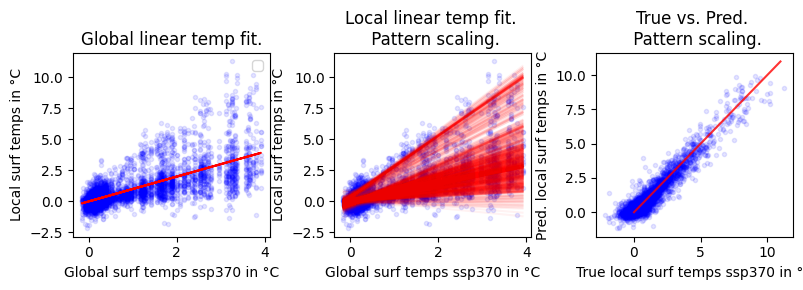

In [ ]:
# Evaluate  model performance
# Calculate metrics, e.g., R-square
# r2 = model_global_lin.score(preds_global_lin, tas_local)

fig, axs = plt.subplots(1,3, figsize =(8,3))
# Plot globally linear model
# preprocess data for eval 
tas_global_cp = np.tile(tas_global[:,np.newaxis, np.newaxis], reps=(1,n_lat,n_lon)) # (n_t, n_lat, n_lon)
tas_global_cp = tas_global_cp.flatten()[:,np.newaxis] # (n_t*n_lat*n_lon, 1)
tas_local_cp = tas_local.flatten()[:,np.newaxis] # # (n_t*n_lat*n_lon, 1)
preds_global_lin_cp = preds_global_lin.flatten()[:,np.newaxis] # # (n_t*n_lat*n_lon, 1)
# Plot only a subsample
n_subsample = 5000
indices = np.arange(n_t*n_lat*n_lon)
indices_subsample = np.random.choice(indices, size=n_subsample, replace=False)
# Plot data
axs[0].scatter(tas_global_cp[indices_subsample], tas_local_cp[indices_subsample], c='blue', marker='.',alpha=0.1)
axs[0].plot(tas_global_cp[indices_subsample], preds_global_lin_cp[indices_subsample], c='red', linestyle='-')
axs[0].set_xlabel("Global surf temps ssp370 in °C")
axs[0].set_ylabel("Local surf temps in °C")
axs[0].set_title(f"Global linear temp fit.")
axs[0].legend()

# Plot pattern scale model
preds_pattern_scaling_cp = preds_pattern_scaling.reshape((n_t,-1)) # (n_t, n_lat*n_lon)
tas_global_cp2 = np.tile(tas_global[:,np.newaxis, np.newaxis], reps=(1,n_lat,n_lon)) # (n_t, n_lat, n_lon)
tas_global_cp2 = tas_global_cp2.reshape((n_t,-1)) # (n_t, n_lat*n_lon)
# plot subsample
n_subsample = 1000
indices = np.arange(n_lat*n_lon)
indices_pattern_scale = np.random.choice(indices, size=n_subsample, replace=False)
axs[1].scatter(tas_global_cp[indices_subsample], tas_local_cp[indices_subsample], c='blue', marker='.',alpha=0.1)
axs[1].plot(tas_global_cp2[:,indices_pattern_scale], preds_pattern_scaling_cp[:,indices_pattern_scale], c='red', linestyle='-', alpha=0.05)
axs[1].set_xlabel("Global surf temps ssp370 in °C")
axs[1].set_ylabel("Local surf temps in °C")
axs[1].set_title(f"Local linear temp fit. \n Pattern scaling.")

# Plot pattern scaling as true vs. pred. scatter plot
tas_local_cp = tas_local.flatten()[:,np.newaxis] # (n_t*n_lat*n_lon,1)
preds_pattern_scaling_cp = preds_pattern_scaling.flatten()[:,np.newaxis] # (n_t*n_lat*n_lon,1)
axs[2].scatter(tas_local_cp[indices_subsample], preds_pattern_scaling_cp[indices_subsample], c='blue', marker='.',alpha=0.1)
axs[2].plot(np.arange(int(tas_local_cp.max())), np.arange(int(tas_local_cp.max())), c='red', linestyle='-', alpha=0.8)
axs[2].set_xlabel("True local surf temps ssp370 in °C")
axs[2].set_ylabel("Pred. local surf temps in °C")
axs[2].set_title(f"True vs. Pred. \n Pattern scaling.")

plt.tight_layout()



#### The linear correlation between local and global temperature strongly varies by location.
- How could the nonlinear error be explaind? E.g., local aerosols, natural local variability 
- The issue does not seem to be the model capacity; local polynomial, random forest, or neural network probably won't increase accuracy.
- Would a linear fit be perfect if I remove interannual variability by smoothing out global and local temperatures with a sliding window?

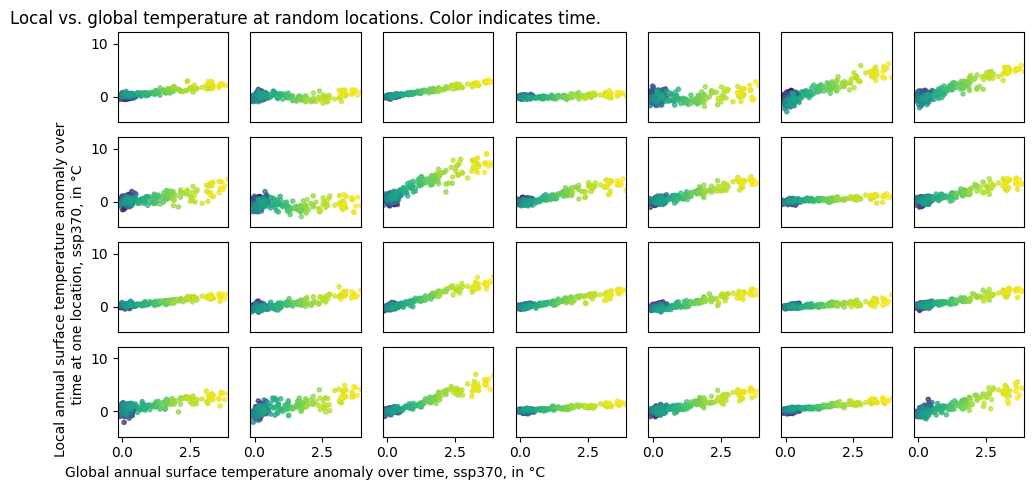

In [ ]:
# Create scatter plot of local vs. global temperatures at random locations

tas_global_cp2 = np.tile(tas_global[:,np.newaxis, np.newaxis], reps=(1,n_lat,n_lon)) # (n_t, n_lat, n_lon)
tas_global_cp2 = tas_global_cp2.reshape((n_t,-1)) # (n_t, n_lat*n_lon)
tas_local_cp = tas_local.reshape((n_t,-1)) # (n_t, n_lat*n_lon)

n_cols = 7
n_rows = 4
n_locations = n_cols*n_rows
fig, axs = plt.subplots(n_rows,n_cols, figsize =(10,5))
xlim = (tas_global_cp2.min(), tas_global_cp2.max())
ylim = (tas_local_cp.min(), tas_local_cp.max())
# sample locations
all_location_idx = np.arange(n_lat*n_lon)
sample_location_idx = np.random.choice(all_location_idx, size=n_locations, replace=False)
for axs_idx, location_idx in enumerate(sample_location_idx):
    row_id = int(axs_idx/n_cols)
    col_id = axs_idx%n_cols
    axs[row_id, col_id].scatter(tas_global_cp2[:,location_idx], tas_local_cp[:,location_idx], c=np.arange(n_t), marker='.', alpha=0.7)
    axs[row_id, col_id].set_xlim(xlim)
    axs[row_id, col_id].set_ylim(ylim)
    # Disable x, and y-axis ticks
    if row_id < n_rows-1: 
        axs[row_id, col_id].get_xaxis().set_visible(False)
    if col_id > 0:
        axs[row_id, col_id].get_yaxis().set_visible(False)
axs[2,0].set_ylabel("Local annual surface temperature anomaly over \n time at one location, ssp370, in °C")
axs[n_rows-1,1].set_xlabel("Global annual surface temperature anomaly over time, ssp370, in °C")
axs[0,1].set_title('Local vs. global temperature at random locations. Color indicates time.')
plt.tight_layout()

### Internal variability in global and local temperatures over time
- There's some correlation between global and local internal variability, but actually not too much. 

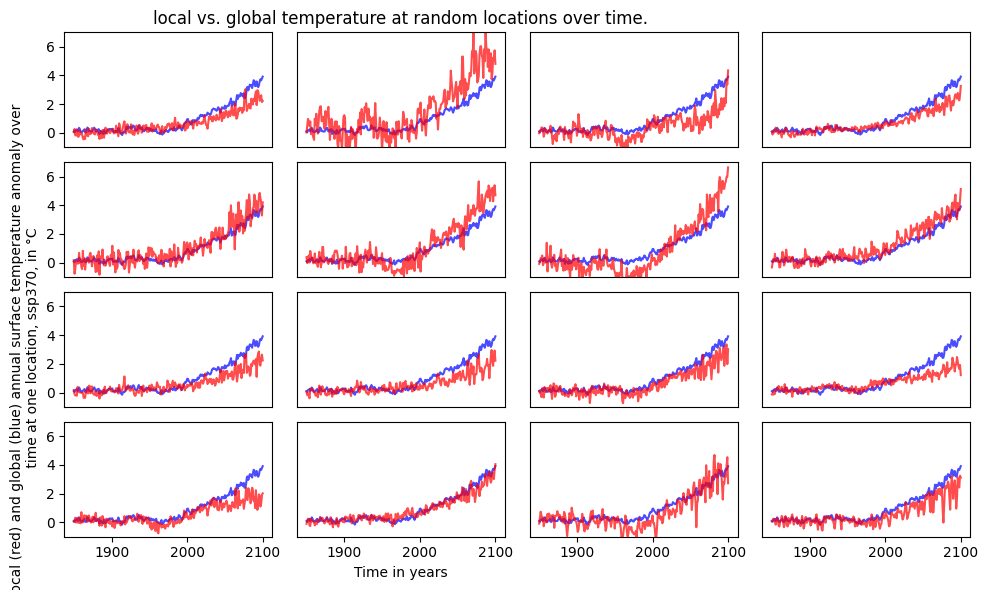

In [ ]:
# plot local and global temperature over time at random locations

time = Y_train[scenario_id].time.data

n_cols = 4
n_rows = 4
n_locations = n_cols*n_rows
fig, axs = plt.subplots(n_rows,n_cols, figsize =(10,6))
ylim = (-1,7) # (tas_local_cp.min(), tas_local_cp.max())
# sample locations
all_location_idx = np.arange(n_lat*n_lon)
sample_location_idx = np.random.choice(all_location_idx, size=n_locations, replace=False)
# display subset of timestamps
sample_time_idx = np.arange(n_t) # first n timesteps 
for axs_idx, location_idx in enumerate(sample_location_idx):
    row_id = int(axs_idx/n_cols)
    col_id = axs_idx%n_cols
    # Plot global temperature curve
    axs[row_id, col_id].plot(time[sample_time_idx], tas_global_cp2[sample_time_idx,location_idx], color='blue', alpha=0.7)
    # Plot local temperature curve
    axs[row_id, col_id].plot(time[sample_time_idx], tas_local_cp[sample_time_idx,location_idx], color='red', alpha=0.7)
    axs[row_id, col_id].set_ylim(ylim)
    # Disable x, and y-axis ticks
    if row_id < n_rows-1: 
        axs[row_id, col_id].get_xaxis().set_visible(False)
    if col_id > 0:
        axs[row_id, col_id].get_yaxis().set_visible(False)
axs[2,0].set_ylabel("Local (red) and global (blue) annual surface temperature anomaly over \n time at one location, ssp370, in °C")
axs[n_rows-1,1].set_xlabel("Time in years")
axs[0,1].set_title('local vs. global temperature at random locations over time.')
plt.tight_layout()

### Plot error over space
- linear pattern scaling breaks down and underpredicts warming in the baltic sea, southern ocean, mid US, Peruvian rainforest, India, China.
    - including aerosols might fix error in India, China
- linear pattern scaling breaks down and overpredicts warming in the arctic ocean+sibera, Mato Grosso (Brazil), Ethiopia, Austria, Larsen ice shelf, 


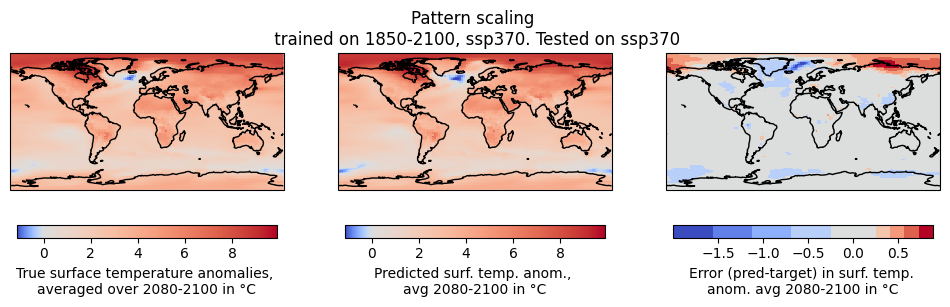

In [ ]:
# Plot error map
from emcli.utils.plotting import plot_tas_annual_local_err_map

preds_pattern_scaling_xr = xr.DataArray(data=preds_pattern_scaling, 
    coords=Y_train[scenario_id]['tas'].coords) # convert predictions into axarray
axs = plot_tas_annual_local_err_map(Y_train[scenario_id]['tas'], preds_pattern_scaling_xr)
axs[1].set_title('Pattern scaling \n trained on 1850-2100, ssp370. Tested on ssp370')
plt.show()


In [31]:
!ls 

config.yaml


In [40]:
from emcli.models.train import main

main(["--cfg_path", "../runs/fcnn/default/config/config.yaml","arg"])

# "--parallel", "False",
#    "--no_wandb",
#   "--verbose"]


Usage: ipykernel_launcher.py [OPTIONS]
Try 'ipykernel_launcher.py --help' for help.

Error: Got unexpected extra argument (arg)


AttributeError: 'tuple' object has no attribute 'tb_frame'